In [1]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math

## Default Setting of Simulations

In [2]:
lr = 0.1   # 0.1
batch_local = 10   # Size of local minibatch
E = 3 #3  # Local training epoch
epoch_max = 300

noise_pow_dBm = -50 #-100
P_dBm = 20  #20
gamma = 0.1  # Target received SNR

sparse_energy = 0.9   # Sparse signal to original energy ratio
undersampl_fr = 0.1

# Measurement matrix generation
B = 1024    # Number of sub-channels

cell_radius = 400
density = 250/(np.pi*500**2) # 250 devices within the circle of radius 500
pathloss_exponent = 4

num_classes = 3   # Number of classes in local dataset
samples_avg_local = 200   # Average number of local samples
samples_CU = samples_avg_local   # Number of samples at CU

regul_coeff = 10e-5   # L2 regularization parameter for avoding overfitting
init_E = E   # Pre-training epoch

g_th = 0.5 * cell_radius ** -pathloss_exponent

## Orthogonal Update Report

In [3]:
acc_list = ['../shared/results/Accuracy/[2021-04-30]Acc_Orth_Acc0.9799Dmax400Dens0.0003CU400.npy',
            '../shared/results/Accuracy/[2021-04-28]Acc_Orth_Acc0.982Dmax400Dens0.0003CU200.npy',            
            '../shared/results/Accuracy/[2021-04-29]Acc_Orth_Acc0.9761Dmax400Dens0.0003CU50.npy',
            '../shared/results/Accuracy/[2021-08-04]Acc_Orth_Acc0.9731Dmax400Dens0.0003CU10P100.0.npy',            
            #'../shared/results/Accuracy/[2021-04-28]Acc_Orth_Acc0.9833Dmax400Dens0.0003CU100.npy',            
           '../shared/results/Accuracy/[2021-05-03]Acc_TCI_Orth_Acc0.1432Dmax400Dens0.0003CU400.npy']
env_list = ['../shared/results/Simulation_Env/[2021-04-30]SimEnv_Orth_Acc0.9799Dmax400Dens0.0003CU400.npz',
            '../shared/results/Simulation_Env/[2021-04-28]SimEnv_Orth_Acc0.982Dmax400Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-04-29]SimEnv_Orth_Acc0.9761Dmax400Dens0.0003CU50.npz',
            '../shared/results/Simulation_Env/[2021-08-04]SimEnv_Orth_Acc0.9731Dmax400Dens0.0003CU10P100.0.npz',             
           #'./results/Simulation_Env/[2021-04-28]SimEnv_Orth_Acc0.9833Dmax400Dens0.0003CU100.npz',           
            '../shared/results/Simulation_Env/[2021-05-03]SimEnv_TCI_Orth_Acc0.1432Dmax400Dens0.0003CU400.npz']
rho_list = ['../shared/results/RHO/[2021-04-30]RHO_Orth_Acc0.9799Dmax400Dens0.0003CU400.npy',
            '../shared/results/RHO/[2021-04-28]RHO_Orth_Acc0.982Dmax400Dens0.0003CU200.npy', 
            '../shared/results/RHO/[2021-04-29]RHO_Orth_Acc0.9761Dmax400Dens0.0003CU50.npy',
            '../shared/results/RHO/[2021-08-04]RHO_Orth_Acc0.9731Dmax400Dens0.0003CU10P100.0.npy',            
           #'../shared/results/RHO/[2021-04-28]RHO_Orth_Acc0.9833Dmax400Dens0.0003CU100.npy',           
           '../shared/results/RHO/[2021-05-03]RHO_TCI_Orth_Acc0.1432Dmax400Dens0.0003CU400.npy']

#legend_list = ['Proposed, $|\mathcal{M}_0|=50$', 'Proposed, $|\mathcal{M}_0|=100$', 'Proposed, $|\mathcal{M}_0|=200$', 'Proposed, $|\mathcal{M}_0|=400$', 'TCI, $|\mathcal{M}_0|=400$']
legend_list = ['Alg.3, $|\mathcal{M}_0|=400$', 'Alg.3, $|\mathcal{M}_0|=200$', 'Alg.3, $|\mathcal{M}_0|=50$','Alg.3, $|\mathcal{M}_0|=10$','TCI, $|\mathcal{M}_0|=400$', 'test']
linestyle = ['-b', '-r', '-g', '-m', '--b', '-.']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


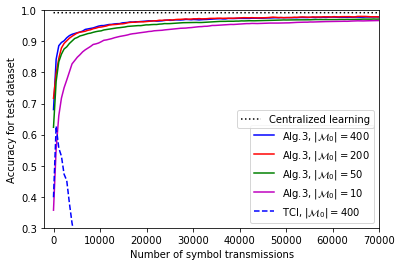

In [4]:
plt.plot(np.arange(70001), 0.9925*np.ones(70001), ':k', label='Centralized learning' )

for i in range(len(acc_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i],label=legend_list[i])    



plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')
#plt.legend(loc='lower right')
lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(1, 6)],[lines[i].get_label() for i in range(1, 6)], loc='lower right')
legend2 = plt.legend([lines[0]],[lines[0].get_label()], loc='right')
plt.gca().add_artist(legend1)
plt.axis([-2000, 70000, 0.3, 1])
#plt.title('Orthogonal Report for Various BS Dataset Size $|\mathcal{M}_0|$')
plt.savefig('./figures/Orth_CUSamples.eps', format='eps')
plt.show()

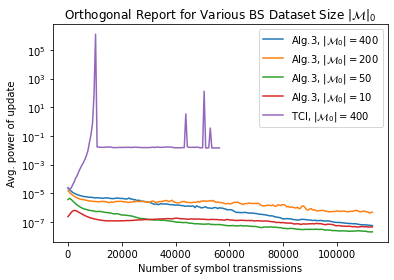

In [5]:
for i in range(len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history, label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
plt.legend(loc='upper right')
plt.title('Orthogonal Report for Various BS Dataset Size $|\mathcal{M}|_0$')
plt.show()

In [6]:
acc_list = [#'../shared/results/Accuracy/[2021-05-02]Acc_Orth_Acc0.9028Dmax100Dens0.0003CU200.npy',
            '../shared/results/Accuracy/[2021-08-04]Acc_Orth_Acc0.8569Dmax0.1Dens0.0003CU200P100.0.npy',
            #'../shared/results/Accuracy/[2021-05-02]Acc_Orth_Acc0.9704Dmax200Dens0.0003CU200.npy',
            '../shared/results/Accuracy/[2021-09-23]Acc_Orth_Acc0.8762Dmax50Dens0.0003CU200P100.0.npy',
            #'../shared/results/Accuracy/[2021-04-28]Acc_Orth_Acc0.982Dmax400Dens0.0003CU200.npy',
            '../shared/results/Accuracy/[2021-08-04]Acc_Orth_Acc0.9816Dmax300Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-04-30]Acc_Orth_Acc0.9819Dmax550Dens0.0003CU200.npy',
           #'../shared/results/Accuracy/[2021-05-04]Acc_TCI_Orth_Acc0.0964Dmax100Dens0.0003CU200.npy',
           #'../shared/results/Accuracy/[2021-05-10]Acc_TCI_Orth_Acc0.1219Dmax400Dens0.0003CU200.npy',
            #'../shared/results/Accuracy/[2021-08-04]Acc_TCI_Orth_Acc0.1104Dmax300Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-23]Acc_TCI_Orth_Acc0.8777Dmax50Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-23]Acc_TCI_Orth_Acc0.1137Dmax300Dens0.0003CU200P100.0.npy',
           '../shared/results/Accuracy/[2021-09-23]Acc_TCI_Orth_Acc0.1099Dmax550Dens0.0003CU200P100.0.npy']
env_list = [#'../shared/results/Simulation_Env/[2021-05-02]SimEnv_Orth_Acc0.9028Dmax100Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-08-04]SimEnv_Orth_Acc0.8569Dmax0.1Dens0.0003CU200P100.0.npz',
            #'../shared/results/Simulation_Env/[2021-05-01]SimEnv_Orth_Acc0.9689Dmax200Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-09-23]SimEnv_Orth_Acc0.8762Dmax50Dens0.0003CU200P100.0.npz',
            #'../shared/results/Simulation_Env/[2021-04-28]SimEnv_Orth_Acc0.982Dmax400Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-08-04]SimEnv_Orth_Acc0.9816Dmax300Dens0.0003CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-04-30]SimEnv_Orth_Acc0.9819Dmax550Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-09-23]SimEnv_TCI_Orth_Acc0.8777Dmax50Dens0.0003CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-23]SimEnv_TCI_Orth_Acc0.1137Dmax300Dens0.0003CU200P100.0.npz',
           #'../shared/results/Simulation_Env/[2021-05-04]SimEnv_TCI_Orth_Acc0.0964Dmax100Dens0.0003CU200.npz',
           #'../shared/results/Simulation_Env/[2021-05-10]SimEnv_TCI_Orth_Acc0.1219Dmax400Dens0.0003CU200.npz',
            #'../shared/results/Simulation_Env/[2021-08-04]SimEnv_TCI_Orth_Acc0.1104Dmax300Dens0.0003CU200P100.0.npz',
           '../shared/results/Simulation_Env/[2021-09-23]SimEnv_TCI_Orth_Acc0.1099Dmax550Dens0.0003CU200P100.0.npz']
rho_list = [#'../shared/results/RHO/[2021-05-02]RHO_Orth_Acc0.9028Dmax100Dens0.0003CU200.npy',
            '../shared/results/RHO/[2021-08-04]RHO_Orth_Acc0.8569Dmax0.1Dens0.0003CU200P100.0.npy',
            #'../shared/results/RHO/[2021-05-02]RHO_Orth_Acc0.9704Dmax200Dens0.0003CU200.npy',
            '../shared/results/RHO/[2021-09-23]RHO_Orth_Acc0.8762Dmax50Dens0.0003CU200P100.0.npy',
            #'../shared/results/RHO/[2021-04-28]RHO_Orth_Acc0.982Dmax400Dens0.0003CU200.npy',
            '../shared/results/RHO/[2021-08-04]RHO_Orth_Acc0.9816Dmax300Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-04-30]RHO_Orth_Acc0.9819Dmax550Dens0.0003CU200.npy',
            '../shared/results/RHO/[2021-09-23]RHO_TCI_Orth_Acc0.8777Dmax50Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-23]RHO_TCI_Orth_Acc0.1137Dmax300Dens0.0003CU200P100.0.npy',
            #'../shared/results/RHO/[2021-05-04]RHO_TCI_Orth_Acc0.0964Dmax100Dens0.0003CU200.npy',
            #'../shared/results/RHO/[2021-05-10]RHO_TCI_Orth_Acc0.1219Dmax400Dens0.0003CU200.npy',
            #'../shared/results/RHO/[2021-08-04]RHO_TCI_Orth_Acc0.1104Dmax300Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-23]RHO_TCI_Orth_Acc0.1099Dmax550Dens0.0003CU200P100.0.npy'
           ]

legend_list = ['No federation, $r_{cvge}=$0m', 'Alg.3, $r_{cvge}=$50m', 'Alg.3, $r_{cvge}=$300m', 'Alg.3, $r_{cvge}=$550m', 'TCI, $r_{cvge}=$50m', 'TCI, $r_{cvge}=$300m','TCI, $r_{cvge}=$550m']
linestyle = [':k', '-g', '-r', '-b', '--g','--r','--b']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


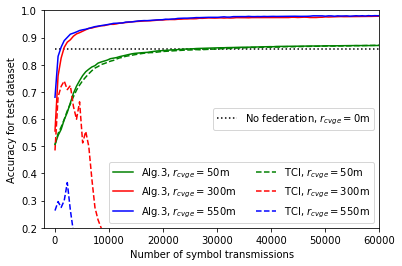

In [7]:
env = np.load(env_list[0])
epoch_max = env['epoch_max']
N = env['N']    
acc_history = np.load(acc_list[0])
plt.plot(np.arange(0,N*epoch_max, N ), np.ones(epoch_max)*acc_history[epoch_max-1], linestyle[0], label=legend_list[0])  

for i in range(1,len(acc_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i],label=legend_list[i])    
    
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')
#plt.legend(loc='lower right')
#plt.title('Orthogonal Report with Various Coverages')

lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(1, 7)],[lines[i].get_label() for i in range(1, 7)], loc='lower right', ncol=2)
legend2 = plt.legend([lines[0]],[lines[0].get_label()], loc='right')
plt.gca().add_artist(legend1)

plt.axis([-2000, 60000, 0.2, 1])
plt.savefig('./figures/Orth_Coverages.eps', format='eps')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (299,) and (300,)

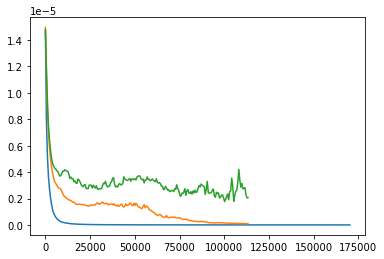

In [8]:
for i in range(1,len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history, label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
plt.legend(loc='upper right')
plt.title('Orthogonal Report with Various Coverages')
plt.show()

In [9]:
acc_list = ['../shared/results/Accuracy/[2021-09-26]Acc_Orth_IDEAL_Acc0.988Dmax400Dens0.0003CU200P10000000000.0.npy', 
            '../shared/results/Accuracy/[2021-05-11]Acc_Orth_Acc0.986Dmax400Dens0.0003CU200P1000.0.npy',
            '../shared/results/Accuracy/[2021-05-02]Acc_Orth_Acc0.9704Dmax200Dens0.0003CU200.npy',
            '../shared/results/Accuracy/[2021-05-11]Acc_Orth_Acc0.9699Dmax400Dens0.0003CU200P10.0.npy',           
            '../shared/results/Accuracy/[2021-09-27]Acc_TCI_Orth_Acc0.916Dmax400Dens0.0003CU200P1000.0.npy',            
            #'../shared/results/Accuracy/[2021-05-12]Acc_TCI_Orth_Acc0.0719Dmax400Dens0.0003CU200P10.0.npy',
           '../shared/results/Accuracy/[2021-05-10]Acc_TCI_Orth_Acc0.1219Dmax400Dens0.0003CU200.npy']
env_list = ['../shared/results/Simulation_Env/[2021-09-26]SimEnv_Orth_IDEAL_Acc0.988Dmax400Dens0.0003CU200P10000000000.0.npz',
            '../shared/results/Simulation_Env/[2021-09-27]SimEnv_TCI_Orth_Acc0.916Dmax400Dens0.0003CU200P1000.0.npz',
            '../shared/results/Simulation_Env/[2021-05-01]SimEnv_Orth_Acc0.9689Dmax200Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-05-11]SimEnv_Orth_Acc0.9699Dmax400Dens0.0003CU200P10.0.npz',
            #'../shared/results/Simulation_Env/[2021-05-12]SimEnv_TCI_Orth_Acc0.0719Dmax400Dens0.0003CU200P10.0.npz',
            '../shared/results/Simulation_Env/[2021-05-12]SimEnv_TCI_Orth_Acc0.9203Dmax400Dens0.0003CU200P1000.npz',
           '../shared/results/Simulation_Env/[2021-05-10]SimEnv_TCI_Orth_Acc0.1219Dmax400Dens0.0003CU200.npz'           ]
rho_list = ['../shared/results/RHO/[2021-09-26]RHO_Orth_IDEAL_Acc0.988Dmax400Dens0.0003CU200P10000000000.0.npy',
            '../shared/results/RHO/[2021-09-27]RHO_TCI_Orth_Acc0.916Dmax400Dens0.0003CU200P1000.0.npy',
            '../shared/results/RHO/[2021-05-02]RHO_Orth_Acc0.9704Dmax200Dens0.0003CU200.npy',
            '../shared/results/RHO/[2021-05-11]RHO_Orth_Acc0.9699Dmax400Dens0.0003CU200P10.0.npy',
            #'../shared/results/RHO/[2021-05-12]RHO_TCI_Orth_Acc0.0719Dmax400Dens0.0003CU200P10.0.npy',
            '../shared/results/RHO/[2021-05-12]RHO_TCI_Orth_Acc0.9203Dmax400Dens0.0003CU200P1000.npy',
            '../shared/results/RHO/[2021-05-10]RHO_TCI_Orth_Acc0.1219Dmax400Dens0.0003CU200.npy']

legend_list = ['Ideal channel', 'Alg.3, $P=30$dBm', 'Alg.3, $P=20$dBm', 'Alg.3, $P=10$dBm', 'TCI, $P=30$dBm', 'TCI, $P=20$dBm']
linestyle = [':k', '-g', '-r', '-b', '--g', '--r']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


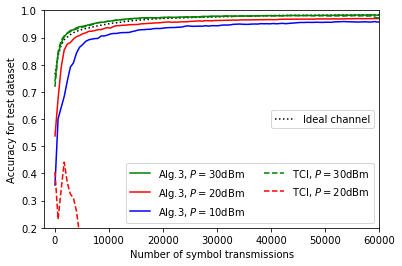

In [10]:
for i in range(len(acc_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history, linestyle[i],label=legend_list[i])    
    
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')
#plt.legend(loc='lower right')
lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(1, 6)],[lines[i].get_label() for i in range(1, 6)], loc='lower right', ncol=2)
legend2 = plt.legend([lines[0]],[lines[0].get_label()], loc='right')
plt.gca().add_artist(legend1)

plt.axis([-2000, 60000, 0.2, 1])
#plt.title('Orthogonal Report with Various Power Budget')
plt.savefig('./figures/Orth_Power.eps', format='eps')
plt.show()

In [ ]:
for i in range(len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history, linestyle[i],label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
plt.legend(loc='upper right')
plt.title('Orthogonal Report with Various Power Budget')
plt.show()

## Compressed Report

In [11]:
'''
acc_list = ['../shared/results/Accuracy/[2021-10-04]Acc_Orth_Acc0.9433Dmax150Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-06]Acc_CS_Acc0.8923CmpRate0.8Dmax150CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-05]Acc_CS_Acc0.8867CmpRate0.4Dmax150CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-07]Acc_CS_Acc0.8742CmpRate0.1Dmax150CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-06]Acc_CS_TCI_Acc0.8844CmpRate0.8Dmax150CU200P100.0.npy',
           '../shared/results/Accuracy/[2021-10-06]Acc_CS_TCI_Acc0.884CmpRate0.4Dmax150CU200P100.0.npy',
           '../shared/results/Accuracy/[2021-10-07]Acc_CS_TCI_Acc0.8778CmpRate0.1Dmax150CU200P100.0.npy']            
env_list = ['../shared/results/Simulation_Env/[2021-10-04]SimEnv_Orth_Acc0.9433Dmax150Dens0.0003CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-06]Sim_CS_Acc0.8923CmpRate0.8Dmax150CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-05]Sim_CS_Acc0.8867CmpRate0.4Dmax150CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-07]Sim_CS_Acc0.8742CmpRate0.1Dmax150CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-06]Sim_CS_TCI_Acc0.8844CmpRate0.8Dmax150CU200P100.0.npz',
           '../shared/results/Simulation_Env/[2021-10-06]Sim_CS_TCI_Acc0.884CmpRate0.4Dmax150CU200P100.0.npz',
           '../shared/results/Simulation_Env/[2021-10-07]Sim_CS_TCI_Acc0.8778CmpRate0.1Dmax150CU200P100.0.npz']
rho_list = ['../shared/results/RHO/[2021-10-04]RHO_Orth_Acc0.9433Dmax150Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-06]RHO_CS_Acc0.8923CmpRate0.8Dmax150CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-05]RHO_CS_Acc0.8867CmpRate0.4Dmax150CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-07]RHO_CS_Acc0.8742CmpRate0.1Dmax150CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-06]RHO_CS_TCI_Acc0.8844CmpRate0.8Dmax150CU200P100.0.npy',
           '../shared/results/RHO/[2021-10-06]RHO_CS_TCI_Acc0.884CmpRate0.4Dmax150CU200P100.0.npy',
           '../shared/results/RHO/[2021-10-07]RHO_CS_TCI_Acc0.8778CmpRate0.1Dmax150CU200P100.0.npy']
legend_list = ['Alg.3, No compression', 'Alg.4, $F_{org}/F=1.25$ ', 'Alg.4, $F_{org}/F=2.5$', 'Alg.4, $F_{org}/F=10$', 'TCI, $F_{org}/F=1.25$','TCI, $F_{org}/F=2.5$',  'TCI, $F_{org}/F=10$']
linestyle = [':k', '-g', '-r', '-b', '--g','--r', '--b']

'''
acc_list = ['../shared/results/Accuracy/[2021-04-28]Acc_Orth_Acc0.982Dmax400Dens0.0003CU200.npy',
            '../shared/results/Accuracy/[2021-09-27]Acc_CS_Acc0.948CmpRate0.8Dmax400CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-16]Acc_CS_Acc0.9348CmpRate0.4Dmax400CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-18]Acc_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-24]Acc_CS_TCI_Acc0.9191CmpRate0.8Dmax400CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-18]Acc_CS_TCI_Acc0.9065CmpRate0.4Dmax400CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-18]Acc_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy']
            
env_list = ['../shared/results/Simulation_Env/[2021-04-28]SimEnv_Orth_Acc0.982Dmax400Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-09-27]Sim_CS_Acc0.948CmpRate0.8Dmax400CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-16]Sim_CS_Acc0.9348CmpRate0.4Dmax400CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-24]Sim_CS_TCI_Acc0.9191CmpRate0.8Dmax400CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_TCI_Acc0.9065CmpRate0.4Dmax400CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npz']
rho_list = ['../shared/results/RHO/[2021-04-28]RHO_Orth_Acc0.982Dmax400Dens0.0003CU200.npy',
            '../shared/results/RHO/[2021-09-27]RHO_CS_Acc0.948CmpRate0.8Dmax400CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-16]RHO_CS_Acc0.9348CmpRate0.4Dmax400CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-18]RHO_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-24]RHO_CS_TCI_Acc0.9191CmpRate0.8Dmax400CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-18]RHO_CS_TCI_Acc0.9065CmpRate0.4Dmax400CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-18]RHO_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy']
legend_list = ['Alg.3, No compress', 'Alg.4, $F_{org}/F=1.25$ ', 'Alg.4, $F_{org}/F=2.5$', 'Alg.4, $F_{org}/F=10$', 'TCI, $F_{org}/F=1.25$','TCI, $F_{org}/F=2.5$',  'TCI, $F_{org}/F=10$']
linestyle = [':k', '-g', '-r', '-b', '--g','--r', '--b']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


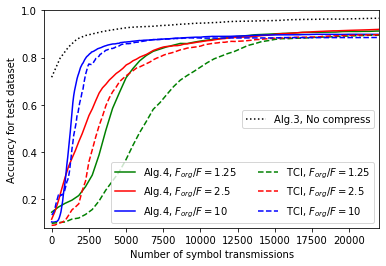

In [12]:
for i in range(len(acc_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N'] 
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i],label=legend_list[i])    
    
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')

lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(1, 7)],[lines[i].get_label() for i in range(1, 7)], loc='lower right', ncol=2)
legend2 = plt.legend([lines[0]],[lines[0].get_label()], loc='right')
plt.gca().add_artist(legend1)
#plt.legend(loc='lower right', ncol=2)
plt.axis([-500, 22000, 0.08, 1])
plt.savefig('./figures/CS_CmpRate.eps', format='eps')
#plt.title('Compressed Report with Compression Rate')
plt.show()

In [ ]:
for i in range(len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history[:epoch_max], linestyle[i], label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
plt.legend(loc='upper right')
#plt.title('Compressed Report with Various Shared Sample Sizes')
plt.show()

In [13]:
acc_list = ['../shared/results/Accuracy/[2021-08-04]Acc_Orth_Acc0.8569Dmax0.1Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-26]Acc_CS_Acc0.8709CmpRate0.1Dmax50CU200P100.0.npy',
            #'../shared/results/Accuracy/[2021-10-03]Acc_CS_Acc0.8757CmpRate0.1Dmax100CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-03]Acc_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npy',
           #'../shared/results/Accuracy/[2021-09-27]Acc_CS_Acc0.8941CmpRate0.1Dmax300CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-18]Acc_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',
           #'../shared/results/Accuracy/[2021-09-28]Acc_CS_Acc0.9039CmpRate0.1Dmax550CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-01]Acc_CS_TCI_Acc0.8774CmpRate0.1Dmax50CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-04]Acc_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npy',
           #'../shared/results/Accuracy/[2021-09-28]Acc_CS_TCI_Acc0.8733CmpRate0.1Dmax300CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-09-18]Acc_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy',
            #'../shared/results/Accuracy/[2021-10-01]Acc_CS_TCI_Acc0.861CmpRate0.1Dmax550CU200P100.0.npy',
           '../shared/results/Accuracy/[2021-09-23]Acc_Orth_Acc0.8762Dmax50Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-04]Acc_Orth_Acc0.9433Dmax150Dens0.0003CU200P100.0.npy',
           #'../shared/results/Accuracy/[2021-08-04]Acc_Orth_Acc0.9816Dmax300Dens0.0003CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-04-28]Acc_Orth_Acc0.982Dmax400Dens0.0003CU200.npy'
           #'../shared/results/Accuracy/[2021-04-30]Acc_Orth_Acc0.9819Dmax550Dens0.0003CU200.npy'
           ]

env_list = ['../shared/results/Simulation_Env/[2021-08-04]SimEnv_Orth_Acc0.8569Dmax0.1Dens0.0003CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-26]Sim_CS_Acc0.8709CmpRate0.1Dmax50CU200P100.0.npz',
            #'../shared/results/Simulation_Env/[2021-10-03]Sim_CS_Acc0.8757CmpRate0.1Dmax100CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-03]Sim_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npz',
           #'../shared/results/Simulation_Env/[2021-09-27]Sim_CS_Acc0.8941CmpRate0.1Dmax300CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npz',
           #'../shared/results/Simulation_Env/[2021-09-28]Sim_CS_Acc0.9039CmpRate0.1Dmax550CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-01]Sim_CS_TCI_Acc0.8774CmpRate0.1Dmax50CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-04]Sim_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npz',
           #'../shared/results/Simulation_Env/[2021-09-28]Sim_CS_TCI_Acc0.8733CmpRate0.1Dmax300CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npz',
            #'../shared/results/Simulation_Env/[2021-10-01]Sim_CS_TCI_Acc0.861CmpRate0.1Dmax550CU200P100.0.npz',
           '../shared/results/Simulation_Env/[2021-09-23]SimEnv_Orth_Acc0.8762Dmax50Dens0.0003CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-04]SimEnv_Orth_Acc0.9433Dmax150Dens0.0003CU200P100.0.npz',
           #'../shared/results/Simulation_Env/[2021-08-04]SimEnv_Orth_Acc0.9816Dmax300Dens0.0003CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-04-28]SimEnv_Orth_Acc0.982Dmax400Dens0.0003CU200.npz'
           #'../shared/results/Simulation_Env/[2021-04-30]SimEnv_Orth_Acc0.9819Dmax550Dens0.0003CU200.npz'
           ]
rho_list = ['../shared/results/RHO/[2021-08-04]RHO_Orth_Acc0.8569Dmax0.1Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-26]RHO_CS_Acc0.8709CmpRate0.1Dmax50CU200P100.0.npy',
            #'../shared/results/RHO/[2021-10-03]RHO_CS_Acc0.8757CmpRate0.1Dmax100CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-03]RHO_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npy',
           #'../shared/results/RHO/[2021-09-27]RHO_CS_Acc0.8941CmpRate0.1Dmax300CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-18]RHO_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',
           #'../shared/results/RHO/[2021-09-28]RHO_CS_Acc0.9039CmpRate0.1Dmax550CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-01]RHO_CS_TCI_Acc0.8774CmpRate0.1Dmax50CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-04]RHO_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npy',
           #'../shared/results/RHO/[2021-09-28]RHO_CS_TCI_Acc0.8733CmpRate0.1Dmax300CU200P100.0.npy',
            '../shared/results/RHO/[2021-09-18]RHO_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy'
            #'../shared/results/RHO/[2021-10-01]RHO_CS_TCI_Acc0.861CmpRate0.1Dmax550CU200P100.0.npy',
           '../shared/results/RHO/[2021-09-23]RHO_Orth_Acc0.8762Dmax50Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-04]RHO_Orth_Acc0.9433Dmax150Dens0.0003CU200P100.0.npy',
           #'../shared/results/RHO/[2021-09-23]RHO_TCI_Orth_Acc0.1137Dmax300Dens0.0003CU200P100.0.npy',
            '../shared/results/RHO/[2021-04-28]RHO_Orth_Acc0.982Dmax400Dens0.0003CU200.npy'
           #'../shared/results/RHO/[2021-04-30]RHO_Orth_Acc0.9819Dmax550Dens0.0003CU200.npy'
           ]


legend_list = ['No federation, $r_{cvge}=$0m', 'Alg.4, $r_{cvge}=$50m', 'Alg.4, $r_{cvge}=$150m', 'Alg.4, $r_{cvge}=$400m', 'TCI, $r_{cvge}=$50m', 'TCI, $r_{cvge}=$150m', 'TCI, $r_{cvge}=$400m', 'Alg. 3, No compress, $r_{cvge}=$50m', 'Alg. 3, No compress, $r_{cvge}=$150m', 'Alg. 3, No compress, $r_{cvge}=$400m']
linestyle = [':k', '-b', '-r', '-g', '--b', '--r','--g', ':b', ':r', ':g']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


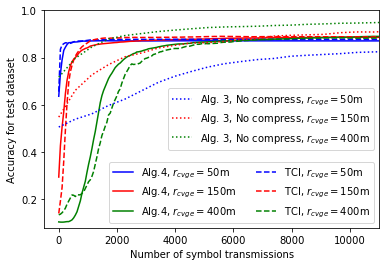

In [14]:
#plt.figure(figsize=(8.2,6))
'''
env = np.load(env_list[0])
epoch_max = env['epoch_max']
N = env['N']    
acc_history = np.load(acc_list[0])
plt.plot(np.arange(0,N*epoch_max, N ), np.ones(epoch_max)*acc_history[epoch_max-1], linestyle[0], label=legend_list[0])  
'''

for i in range(1,10):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i], label=legend_list[i])    
'''
for i in range(7,10):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i])    
'''

lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(6)],[lines[i].get_label() for i in range(6)], loc='lower right', ncol=2)
legend2 = plt.legend([lines[i] for i in range(6, 9)],[lines[i].get_label() for i in range(6, 9)], loc='right')
plt.gca().add_artist(legend1)

plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')
#plt.legend(loc='lower right', ncol=3, fontsize=10)
#plt.title('Compressed Report with Various Coverage')
plt.axis([-500, 11000, 0.08, 1])
plt.savefig('./figures/CS_Coverage.eps', format='eps')
plt.show()

In [ ]:
for i in range(len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history[:epoch_max], label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
plt.legend(loc='upper right')
plt.title('Compressed Report with Various Coverage')
plt.show()

In [15]:
#Coverage 150
acc_list = ['../shared/results/Accuracy/[2021-10-23]Acc_CS_Acc0.8855CmpRate0.1Dmax150Dens0.0003CU200.npy',
            '../shared/results/Accuracy/[2021-10-14]Acc_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.npy',
            '../shared/results/Accuracy/[2021-10-06]Acc_CS_Acc0.8778CmpRate0.1Dmax150CU200P10.0.npy',
            '../shared/results/Accuracy/[2021-10-03]Acc_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-12]Acc_CS_Acc0.8822CmpRate0.1Dmax150CU200P1000.0.npy',
            '../shared/results/Accuracy/[2021-10-14]Acc_CS_TCI_Acc0.881CmpRate0.1Dmax150CU200P1.0.npy',
            '../shared/results/Accuracy/[2021-10-11]Acc_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.npy',
           '../shared/results/Accuracy/[2021-10-04]Acc_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npy',
           '../shared/results/Accuracy/[2021-10-08]Acc_CS_TCI_Acc0.8925CmpRate0.1Dmax150CU200P1000.0.npy']
env_list = ['../shared/results/Simulation_Env/[2021-10-23]Sim_CS_Acc0.8855CmpRate0.1Dmax150Dens0.0003CU200.npz',
            '../shared/results/Simulation_Env/[2021-10-14]Sim_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.npz',
            '../shared/results/Simulation_Env/[2021-10-06]Sim_CS_Acc0.8778CmpRate0.1Dmax150CU200P10.0.npz',
            '../shared/results/Simulation_Env/[2021-10-03]Sim_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-12]Sim_CS_Acc0.8822CmpRate0.1Dmax150CU200P1000.0.npz',
            '../shared/results/Simulation_Env/[2021-10-14]Sim_CS_TCI_Acc0.881CmpRate0.1Dmax150CU200P1.0.npz',
            '../shared/results/Simulation_Env/[2021-10-11]Sim_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.npz',
            '../shared/results/Simulation_Env/[2021-10-04]Sim_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npz',
           '../shared/results/Simulation_Env/[2021-10-08]Sim_CS_TCI_Acc0.8925CmpRate0.1Dmax150CU200P1000.0.npz']
rho_list = ['../shared/results/RHO/[2021-10-23]RHO_CS_Acc0.8855CmpRate0.1Dmax150Dens0.0003CU200.npy'
            '../shared/results/RHO/[2021-10-14]RHO_CS_Acc0.8877CmpRate0.1Dmax150CU200P1.0.npy',
            '../shared/results/RHO/[2021-10-06]RHO_CS_Acc0.8778CmpRate0.1Dmax150CU200P10.0.npy',
            '../shared/results/RHO/[2021-10-03]RHO_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-12]RHO_CS_Acc0.8822CmpRate0.1Dmax150CU200P1000.0.npy',
            '../shared/results/RHO/[2021-10-14]RHO_CS_TCI_Acc0.881CmpRate0.1Dmax150CU200P1.0.npy',
            '../shared/results/RHO/[2021-10-11]RHO_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.npy',
            '../shared/results/RHO/[2021-10-04]RHO_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npy',
           '../shared/results/RHO/[2021-10-08]RHO_CS_TCI_Acc0.8925CmpRate0.1Dmax150CU200P1000.0.npy']
legend_list = ['Alg.4, Ideal channel', 'Alg.4, $P=0$dBm', 'Alg.4, $P=10$dBm', 'Alg.4, $P=20$dBm', 'Alg.4, $P=30$dBm', 'TCI, $P=0$dBm','TCI, $P=10$dBm', 'TCI, $P=20$dBm', 'TCI, $P=30$dBm']
linestyle = [':k','-m','-b', '-r', '-g', '--m','--b', '--r','--g']


'''
#Coverage = 400m
acc_list = ['../shared/results/Accuracy/[2021-10-02]Acc_CS_Acc0.8788CmpRate0.1Dmax400CU200P10.0.npy',
            '../shared/results/Accuracy/[2021-09-18]Acc_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-05]Acc_CS_Acc0.9068CmpRate0.1Dmax400CU200P1000.0.npy',
           '../shared/results/Accuracy/[2021-09-18]Acc_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy']
env_list = ['../shared/results/Simulation_Env/[2021-10-02]Sim_CS_Acc0.8788CmpRate0.1Dmax400CU200P10.0.npz',
            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-05]Sim_CS_Acc0.9068CmpRate0.1Dmax400CU200P1000.0.npz',
           '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npz']
rho_list = ['../shared/results/RHO/[2021-10-02]RHO_CS_Acc0.8788CmpRate0.1Dmax400CU200P10.0.npy',
            '../shared/results/RHO/[2021-09-18]RHO_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-05]RHO_CS_Acc0.9068CmpRate0.1Dmax400CU200P1000.0.npy',
           '../shared/results/RHO/[2021-09-18]RHO_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy']
legend_list = ['Alg.4, $P=10$dBm', 'Alg.4, $P=20$dBm', 'Alg.4, $P=30$dBm', 'TCI, $P=10$dBm', 'TCI, $P=20$dBm', 'TCI, $P=30$dBm']
linestyle = ['-b', '-r', '-g', '--b', '--r','--g']
'''

"\n#Coverage = 400m\nacc_list = ['../shared/results/Accuracy/[2021-10-02]Acc_CS_Acc0.8788CmpRate0.1Dmax400CU200P10.0.npy',\n            '../shared/results/Accuracy/[2021-09-18]Acc_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npy',\n            '../shared/results/Accuracy/[2021-10-05]Acc_CS_Acc0.9068CmpRate0.1Dmax400CU200P1000.0.npy',\n           '../shared/results/Accuracy/[2021-09-18]Acc_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npy']\nenv_list = ['../shared/results/Simulation_Env/[2021-10-02]Sim_CS_Acc0.8788CmpRate0.1Dmax400CU200P10.0.npz',\n            '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_Acc0.8981CmpRate0.1Dmax400CU200P100.0.npz',\n            '../shared/results/Simulation_Env/[2021-10-05]Sim_CS_Acc0.9068CmpRate0.1Dmax400CU200P1000.0.npz',\n           '../shared/results/Simulation_Env/[2021-09-18]Sim_CS_TCI_Acc0.8852CmpRate0.1Dmax400CU200P100.0.npz']\nrho_list = ['../shared/results/RHO/[2021-10-02]RHO_CS_Acc0.8788CmpRate0.1Dmax400CU200P10.0.npy',\n            '../sha

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


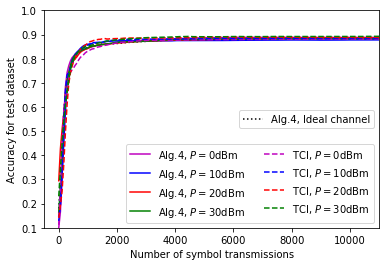

In [16]:
for i in range(len(acc_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i], label=legend_list[i])    
    
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')
#plt.legend(loc='lower right', ncol=2)

lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(1, 9)],[lines[i].get_label() for i in range(1, 9)], loc='lower right', ncol=2)
legend2 = plt.legend([lines[0]],[lines[0].get_label()], loc='right')
plt.gca().add_artist(legend1)

#plt.title('Compressed Report with Various Power Budget')
plt.axis([-500, 11000, 0.1, 1])
plt.savefig('./figures/CS_Pow.eps', format='eps')
plt.show()

In [ ]:
for i in range(len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history[:epoch_max], label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
#plt.legend(loc='upper right')

lines = plt.gca().get_lines()
legend1 = plt.legend([lines[i] for i in range(1, 9)],[lines[i].get_label() for i in range(1, 7)], loc='lower right', ncol=2)
legend2 = plt.legend([lines[0]],[lines[0].get_label()], loc='right')
plt.gca().add_artist(legend1)

plt.title('Compressed Report with Various Coverage')
plt.show()

In [17]:
acc_list = [#'../shared/results/Accuracy/[2021-10-08]Acc_CS_Acc0.7805CmpRate0.1Dmax150CU50P100.0.npy',
            '../shared/results/Accuracy/[2021-10-22]Acc_CS_Acc0.83CmpRate0.1Dmax150CU100P100.0.npy',
           '../shared/results/Accuracy/[2021-10-03]Acc_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npy',
            '../shared/results/Accuracy/[2021-10-08]Acc_CS_Acc0.9142CmpRate0.1Dmax150CU400P100.0.npy',
            #'../shared/results/Accuracy/[2021-10-08]Acc_CS_TCI_Acc0.2172CmpRate0.1Dmax150CU10P100.0.npy',
            #'../shared/results/Accuracy/[2021-10-08]Acc_CS_TCI_Acc0.7405CmpRate0.1Dmax150CU50P100.0.npy',
            '../shared/results/Accuracy/[2021-10-22]Acc_CS_TCI_Acc0.8196CmpRate0.1Dmax150CU100P100.0.npy',
           '../shared/results/Accuracy/[2021-10-04]Acc_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npy',
           '../shared/results/Accuracy/[2021-10-12]Acc_CS_TCI_Acc0.9186CmpRate0.1Dmax150CU400P100.0.npy']
env_list = [#'../shared/results/Simulation_Env/[2021-10-08]Sim_CS_Acc0.7805CmpRate0.1Dmax150CU50P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-22]Sim_CS_Acc0.83CmpRate0.1Dmax150CU100P100.0.npz',
           '../shared/results/Simulation_Env/[2021-10-03]Sim_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-08]Sim_CS_Acc0.9142CmpRate0.1Dmax150CU400P100.0.npz',
            #'../shared/results/Simulation_Env/[2021-10-08]Sim_CS_TCI_Acc0.2172CmpRate0.1Dmax150CU10P100.0.npz',
            #'../shared/results/Simulation_Env/[2021-10-08]Sim_CS_TCI_Acc0.7405CmpRate0.1Dmax150CU50P100.0.npz',
            '../shared/results/Simulation_Env/[2021-10-22]Sim_CS_TCI_Acc0.8196CmpRate0.1Dmax150CU100P100.0.npz',
           '../shared/results/Simulation_Env/[2021-10-04]Sim_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npz',
           '../shared/results/Simulation_Env/[2021-10-12]Sim_CS_TCI_Acc0.9186CmpRate0.1Dmax150CU400P100.0.npz']
rho_list = [#'../shared/results/RHO/[2021-10-08]RHO_CS_Acc0.7805CmpRate0.1Dmax150CU50P100.0.npy',
            '../shared/results/RHO/[2021-10-22]RHO_CS_Acc0.83CmpRate0.1Dmax150CU100P100.0.npy',
           '../shared/results/RHO/[2021-10-03]RHO_CS_Acc0.886CmpRate0.1Dmax150CU200P100.0.npy',
            '../shared/results/RHO/[2021-10-08]RHO_CS_Acc0.9142CmpRate0.1Dmax150CU400P100.0.npy',
            #'../shared/results/RHO/[2021-10-08]RHO_CS_TCI_Acc0.2172CmpRate0.1Dmax150CU10P100.0.npy',
            #'../shared/results/RHO/[2021-10-08]RHO_CS_TCI_Acc0.7405CmpRate0.1Dmax150CU50P100.0.npy',
            '../shared/results/RHO/[2021-10-22]RHO_CS_TCI_Acc0.8196CmpRate0.1Dmax150CU100P100.0.npy',
           '../shared/results/RHO/[2021-10-04]RHO_CS_TCI_Acc0.8879CmpRate0.1Dmax150CU200P100.0.npy',
           '../shared/results/RHO/[2021-10-12]RHO_CS_TCI_Acc0.9186CmpRate0.1Dmax150CU400P100.0.npy']
legend_list = [ 'Alg.4, $|\mathcal{M}_0|=100$','Alg.4, $|\mathcal{M}_0|=200$', 'Alg.4, $|\mathcal{M}_0|=400$','TCI, $|\mathcal{M}_0|=100$','TCI, $|\mathcal{M}_0|=200$', 'TCI, $|\mathcal{M}_0|=400$']
linestyle = ['-b', '-r', '-g', '--b', '--r','--g']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


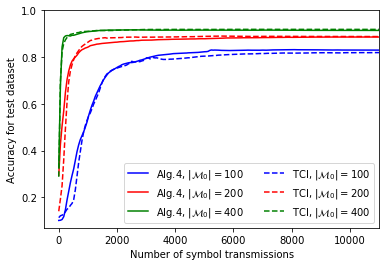

In [18]:
for i in range(len(acc_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    acc_history = np.load(acc_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), acc_history[:epoch_max], linestyle[i],label=legend_list[i])    
    
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Accuracy for test dataset')
plt.legend(loc='lower right', ncol=2)
#plt.title('Compressed Report with Various BS Dataset Size $|\mathcal{M}_0|$')
plt.axis([-500, 11000, 0.07, 1])
plt.savefig('./figures/CS_DatasetSize.eps', format='eps')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (199,) and (200,)

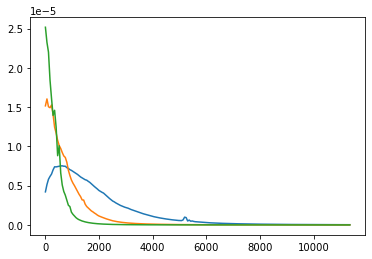

In [19]:
for i in range(len(rho_list)):
    env = np.load(env_list[i])
    epoch_max = env['epoch_max']
    N = env['N']    
    rho_history = np.load(rho_list[i])
    plt.plot(np.arange(0,N*epoch_max, N ), rho_history, label=legend_list[i])        
plt.xlabel('Number of symbol transmissions')
plt.ylabel('Avg. power of update')
plt.yscale("log")
plt.legend(loc='upper right')
plt.title('Compressed Report with Various BS Dataset Size $|\mathcal{M}_0|$')
plt.show()

In [ ]:
print(len(acc_history))
print(epoch_max)
print(i)

plt.plot(np.arange(0,N*epoch_max, N), acc_history, linestyle[i],label=legend_list[i])    
